# VGG19 Transfer learning Model

## Import libraries

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#google colab mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import glob as gb
import cv2
import tensorflow as tf
import os


#sklearn
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#For image preprocessing
from  tensorflow.keras import preprocessing
from keras.preprocessing import image
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#for google colab, primary computer
augmented_images_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Augmented Images'
original_image_path= '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Original Images'
val1_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Val'
test1_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test'
train1_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Train'
test_image = tf.keras.utils.load_img('/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Monkeypox/M04_01.jpg', target_size = (224, 224))
test_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test'

## Preprocessing/resizing photo

In [ ]:
training1_set = preprocessing.image_dataset_from_directory(directory=train1_path,
                                                 image_size = (224, 224),
                                                 batch_size = 32,
                                                 label_mode="binary")
test1_set = preprocessing.image_dataset_from_directory(directory=test1_path,
                                            image_size = (224, 224),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)
val1_set = preprocessing.image_dataset_from_directory(directory=val1_path,
                                            image_size = (224, 224),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


## Modeling

In [ ]:
#vgg19 base model

#include_top= false; load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
vgg19 = VGG19(input_shape=(224, 224, 3), 
            weights='imagenet',
            pooling=None, 
            input_tensor=None, 
            include_top=False)

#keep weights frozen. Keeping them frozen will allow the model to stick to what generic features it has learnt before. 
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
#layers after the vgg19 model
x = GlobalAveragePooling2D()(vgg19.output)
x2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x3 = Dense(units= '6000', activation='relu')(x2)
x4 = BatchNormalization()(x3)
x5 = Dense(units= '200', activation='relu')(x4)
x6 = BatchNormalization()(x5)
x7 = Dropout(0.4)(x6)


#adding output layer.
prediction = Dense(1,activation='sigmoid')(x7)

vgg19model = Model(inputs=vgg19.input, outputs=prediction)
# view the structure of the model
vgg19model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg19model.compile(
  loss='binary_crossentropy',
  optimizer= "Adam",
  metrics=['acc']
)

In [ ]:
#Early stopping to avoid overfitting of model
#patience is the number of epochs without improvement after which training will be early stopped
# checkpoint and early stopping
filepath="/content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_acc',mode='max', patience=20)
callbacks_list = [checkpoint, es]

In [ ]:
# fit the model
history = vgg19model.fit(
  x = training1_set,  validation_data = val1_set,
  epochs=300,
  callbacks=[checkpoint, es],
  batch_size=32,
  shuffle=True
  )

Epoch 1/300
67/67 [==============================] - ETA: 0s - loss: 0.5393 - acc: 0.7792
Epoch 1: val_acc improved from -inf to 0.70000, saving model to /content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5
67/67 [==============================] - 720s 9s/step - loss: 0.5393 - acc: 0.7792 - val_loss: 0.5664 - val_acc: 0.7000
Epoch 2/300
67/67 [==============================] - ETA: 0s - loss: 0.2323 - acc: 0.9048
Epoch 2: val_acc did not improve from 0.70000
67/67 [==============================] - 15s 215ms/step - loss: 0.2323 - acc: 0.9048 - val_loss: 0.6768 - val_acc: 0.6333
Epoch 3/300
67/67 [==============================] - ETA: 0s - loss: 0.2170 - acc: 0.9174
Epoch 3: val_acc did not improve from 0.70000
67/67 [==============================] - 15s 216ms/step - loss: 0.2170 - acc: 0.9174 - val_loss: 0.7216 - val_acc: 0.5976
Epoch 4/300
67/67 [==============================] - ETA: 0s - loss: 0.1846 - acc: 0.9276
Epoch 4: val_acc did not improve from 0.70000
67/67 [===========

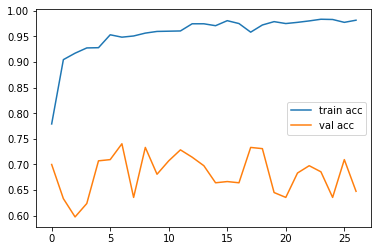

In [ ]:
#Accuracies
#Accuracy score is the number of correct predictions obtained.
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

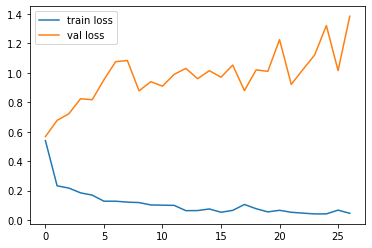

In [ ]:
# loss
#Loss values are the values indicating the difference from the desired target state(s)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
vgg19model.save("vgg19_model")

## Tuning

In [ ]:
#unfreeze layers
vgg19.trainable = True

In [ ]:
# Number of layers in base model
print("Number of layers in the base model: ", len(vgg19.layers))

Number of layers in the base model:  22


In [ ]:
vgg19model.compile(
  loss='binary_crossentropy',
  optimizer= 'Adamax',
  metrics=['accuracy']
)

In [ ]:
filepath="/content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=20)
callbacks_list = [checkpoint, es]

In [ ]:
# fit the model
history2 = vgg19model.fit(
  x = training1_set,  validation_data = val1_set,
  epochs=110,
  callbacks=[callbacks_list],
  batch_size=32,
  shuffle=True)

Epoch 1/110
67/67 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.5738
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to /content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5
67/67 [==============================] - 47s 605ms/step - loss: 0.9600 - accuracy: 0.5738 - val_loss: 8.7907 - val_accuracy: 0.4000
Epoch 2/110
67/67 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.6223
Epoch 2: val_accuracy did not improve from 0.40000
67/67 [==============================] - 35s 522ms/step - loss: 0.6745 - accuracy: 0.6223 - val_loss: 2.2120 - val_accuracy: 0.4000
Epoch 3/110
67/67 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.6653
Epoch 3: val_accuracy improved from 0.40000 to 0.42143, saving model to /content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5
67/67 [==============================] - 39s 579ms/step - loss: 0.6332 - accuracy: 0.6653 - val_loss: 1.6248 - val_accuracy: 0.4214
Epoch 4/110
67/

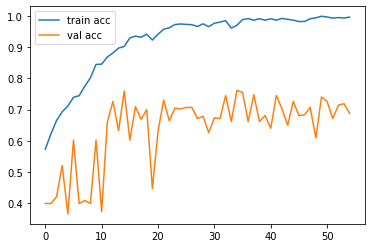

In [ ]:
#Accuracies
#Accuracy score is the number of correct predictions obtained.
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

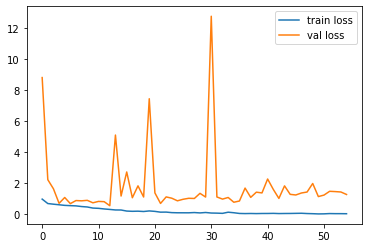

In [ ]:
# loss
#Loss values are the values indicating the difference from the desired target state(s)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
#evaluate
loss, accuracy = vgg19model.evaluate(test1_set)
print('Test accuracy :', accuracy)

2/2 [==============================] - 17s 5s/step - loss: 0.4403 - accuracy: 0.8222
Test accuracy : 0.8222222328186035


In [ ]:
vgg19model.save("vgg19_model")

## Predict

In [ ]:
vgg19model.load_weights("/content/drive/MyDrive/DSI30/Capstone/vgg19weights.hdf5")

In [ ]:
#model evaultion
vgg19model.evaluate(test1_set,batch_size=32)

2/2 [==============================] - 0s 99ms/step - loss: 0.8793 - accuracy: 0.7333


[0.8793423175811768, 0.7333333492279053]

In [ ]:
y_pred = tf.math.round(vgg19model.predict(test1_set))
y_true = []
for images, labels in test1_set.unbatch():
  y_true.append(labels.numpy())

In [ ]:
accuracy_score(y_true, y_pred)

0.7333333333333333

In [ ]:
print(classification_report(y_true, y_pred, target_names=training1_set.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.83      0.50      0.62        20
      Others       0.70      0.92      0.79        25

    accuracy                           0.73        45
   macro avg       0.77      0.71      0.71        45
weighted avg       0.76      0.73      0.72        45



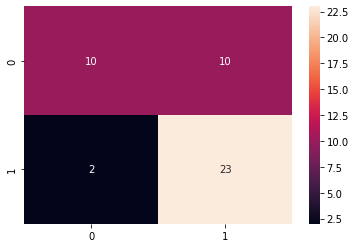

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True);

In [ ]:
#secondary account/computer

df = []


#for folder in  os.listdir(test_path) : 
files = gb.glob(pathname= str(test_path +'/' + 'Monkeypox' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[10], imagesplit[9]]
  df.append(imagename)

files = gb.glob(pathname= str(test_path +'/' + 'Others' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[10], imagesplit[9]]
  df.append(imagename)

df2 =[]
for pred in y_pred:
      pred = str(pred)
      filter = (pred.split('.'))[1]
      filter2 = (filter.split('['))[1]
      df2.append(filter2)

df = pd.DataFrame (df, columns = ['file_name', 'class'])

df['pred']= df2
df

,file_name,class,pred
0,Monkeypox,Test,0
1,Monkeypox,Test,0
2,Monkeypox,Test,1
3,Monkeypox,Test,1
4,Monkeypox,Test,1
5,Monkeypox,Test,1
6,Monkeypox,Test,0
7,Monkeypox,Test,0
8,Monkeypox,Test,0
9,Monkeypox,Test,1
